## Load and inspect the dataset

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('spam.csv', encoding='latin-1')

print(df.head()) # printing the first 5 rows of the dataframe

print(df.info()) # printing the info of the dataframe

print(df.describe()) 

                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB
None
              spam
count  5728.000000
mean      0.238827
std       0.426404
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


In [2]:
print(df.isnull().sum()) # check for missing values

text    0
spam    0
dtype: int64


In [3]:
df['text'] = pd.Series(text[9:] for text in df['text']) # removing (Subject:) from the text column

## Visualizing Spam Message Data Using Word Clouds

In [4]:
spam_df = df[df.spam == 1] # filtering the spam messages
spam_messages = spam_df['text'] # getting the spam messages


In [5]:
all_spam = " ".join(message for message in spam_messages)
print(f"There are {len(all_spam)} words in the combination of all spam messages.")

There are 1791063 words in the combination of all spam messages.


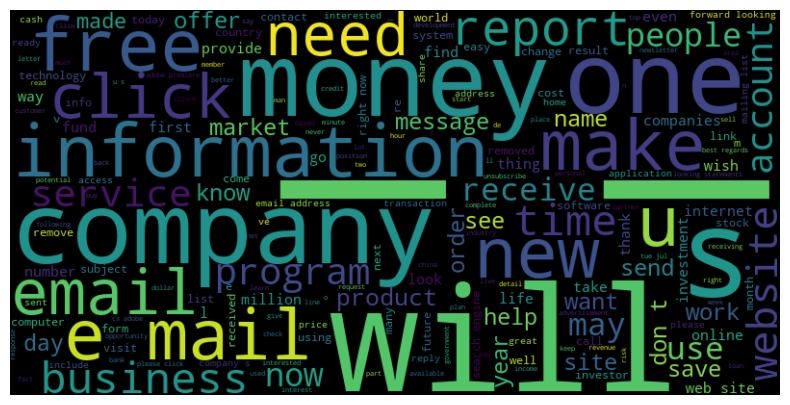

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='black').generate(all_spam)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # axes not shown to keep it clean
plt.show()


## Preprocessing and Feature Extraction

In [11]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def clean_text(text):
    # Removing non-letters
    text = re.sub(r'\s+', ' ', text) # replacing multiple spaces with a single space
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    # Convert to lower case and split into words
    words = letters_only.lower().split()
    # Removing stopwords
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    # Joining the words back into one string separated by space and return the result
    return " ".join(meaningful_words)

df['clean_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adhir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initializing the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])

df['label'] = df['spam'].map({0: 'ham', 1: 'spam'})

# Getting the labels
y = df['spam']


In [13]:
from sklearn.model_selection import train_test_split

# Splitting the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Building and Compiling a Neural Network

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

In [163]:
model = Sequential([
    # Input layer and first hidden layer
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.7),

    # Second hidden layer
    Dense(64, activation='relu'),
    Dropout(0.6),

    # Output layer
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])


In [164]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Appropriate loss function for binary classification
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)


In [165]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

## Training a Neural Network with Early Stopping

In [166]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,         # Number of epochs to wait after min has been reached
    restore_best_weights=True  # Restoring model weights from the epoch with the lowest validation loss
    )

history = model.fit(
    X_train, 
    y_train,
    epochs=100,  # Max number of epochs
    callbacks=[early_stopping],
    batch_size=64,  # Batch size for training
    validation_split=0.2
)


Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7028 - auc: 0.6135 - loss: 0.6140 - precision: 0.3171 - recall: 0.1563 - val_accuracy: 0.7819 - val_auc: 0.9957 - val_loss: 0.3012 - val_precision: 1.0000 - val_recall: 0.0196
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8489 - auc: 0.9939 - loss: 0.2618 - precision: 0.9957 - recall: 0.4008 - val_accuracy: 0.9815 - val_auc: 0.9987 - val_loss: 0.0722 - val_precision: 0.9606 - val_recall: 0.9559
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9900 - auc: 0.9995 - loss: 0.0589 - precision: 0.9881 - recall: 0.9690 - val_accuracy: 0.9869 - val_auc: 0.9993 - val_loss: 0.0300 - val_precision: 0.9660 - val_recall: 0.9755
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9963 - auc: 0.9999 - loss: 0.0201 - precision: 0.9928 - recall: 0.9920 - val_accuracy: 0.9902 - val_auc: 0.9995 - val_loss: 0.0254 - val_precision: 0.9803 - val_recall: 0.9755
Epoch 5/100
58/58 ━━━━━━━━━━━━━━

## Evaluating the Performance of the Classification Model

In [167]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # Converting probabilities to binary output


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [168]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_test, predictions, target_names=['Ham', 'Spam'])
print(report)


              precision    recall  f1-score   support

         Ham       0.99      1.00      1.00       856
        Spam       0.99      0.98      0.99       290

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



In [169]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

[[854   2]
 [  6 284]]


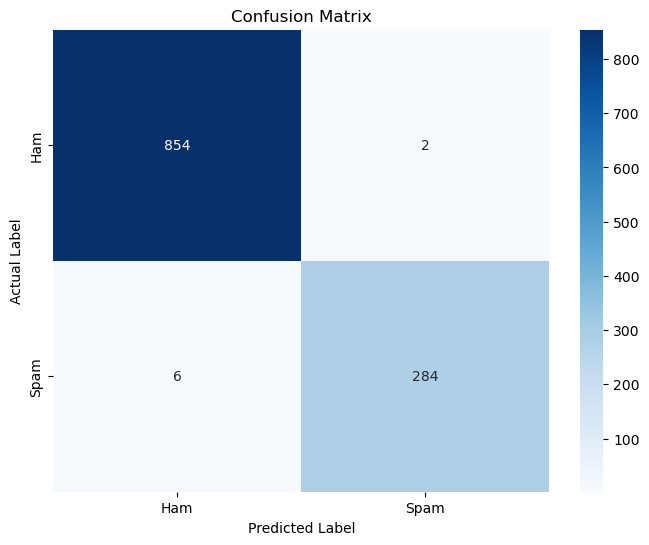

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


## Visualizing Comprehensive Performance Metrics

In [171]:
import matplotlib.pyplot as plt

# Extracting the data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(acc) + 1)


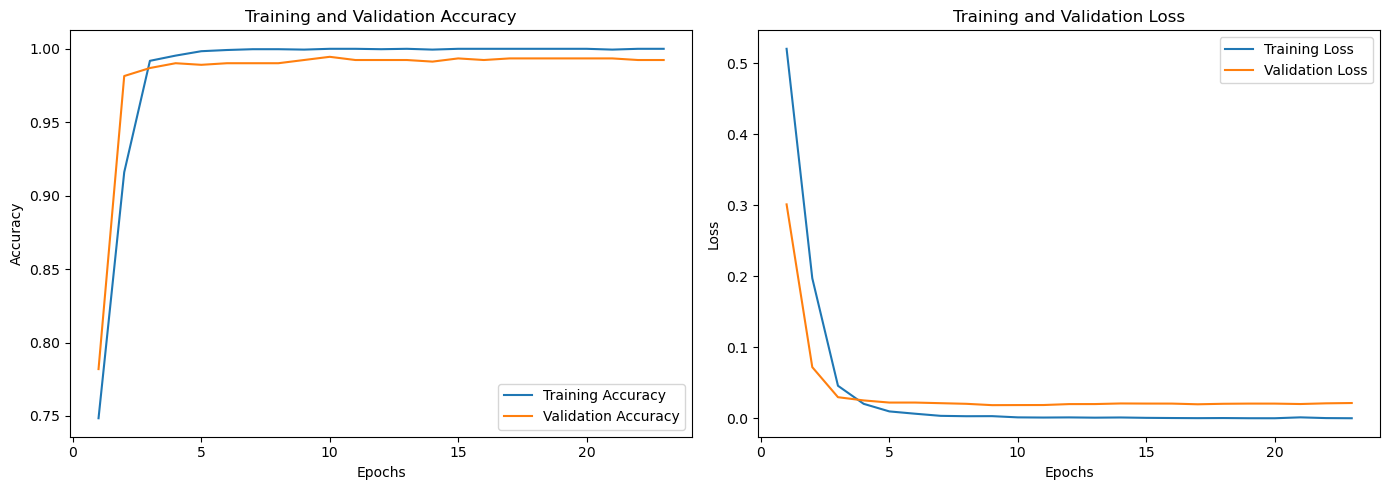

In [172]:
plt.figure(figsize=(14, 5))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


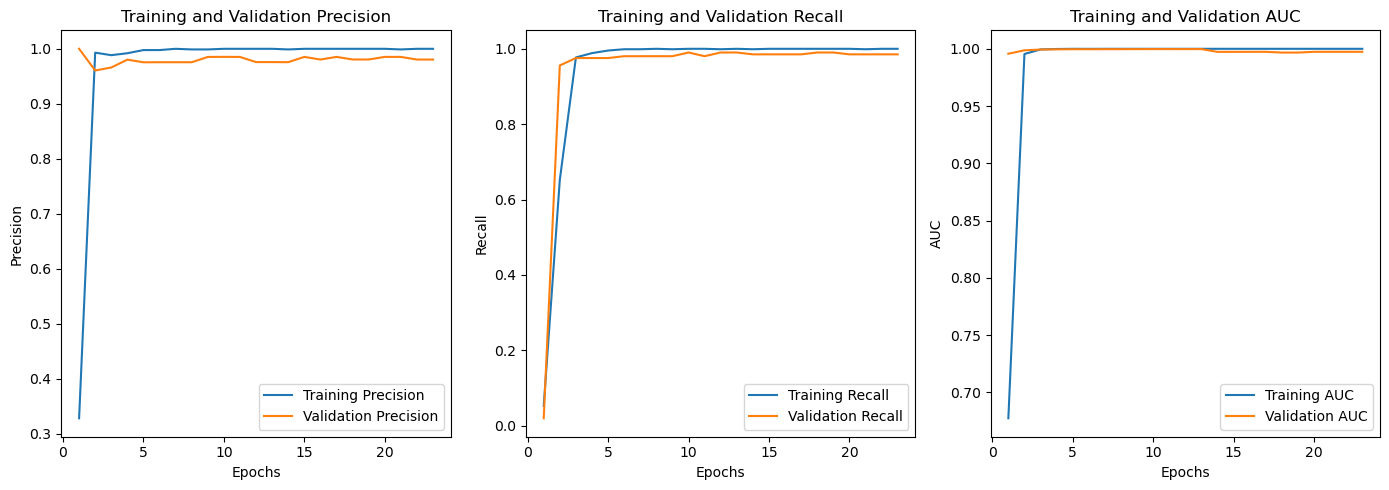

In [173]:
plt.figure(figsize=(14, 5))

# Plotting precision
plt.subplot(1, 3, 1)
plt.plot(epochs, precision, label='Training Precision')
plt.plot(epochs, val_precision, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting recall
plt.subplot(1, 3, 2)
plt.plot(epochs, recall, label='Training Recall')
plt.plot(epochs, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


## Hyperparameter Optimization for Neural Network

In [152]:
from kerastuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam

class SpamClassifierHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential([
            Dense(
                units=hp.Int('input_units', min_value=32, max_value=512, step=32),
                activation='relu',
                input_shape=(self.input_dim,)
            ),
            Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.7, default=0.25, step=0.05)),
            Dense(
                units=hp.Int('hidden_units', min_value=32, max_value=128, step=32),
                activation='relu'
            ),
            Dropout(rate=hp.Float('dropout2', min_value=0.0, max_value=0.6, default=0.25, step=0.05)),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        return model


In [154]:
hypermodel = SpamClassifierHyperModel(input_dim=X_train.shape[1])

tuner = Hyperband(
    hypermodel,
    objective='val_auc',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='spam_classification2'
)


c:\UoS_Lab\Anaconda\envs\com6018\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [155]:
early_stopping = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Trial 90 Complete [00h 02m 55s]
val_auc: 0.9997971653938293

Best val_auc So Far: 0.9999106526374817
Total elapsed time: 00h 19m 40s


In [156]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Best model summary:')
best_model.summary()
print('Best hyperparameters:', best_hyperparameters.values)


Best model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 192)            │       960,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 966,401 (3.69 MB)

 Trainable params: 966,401 (3.69 MB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameters: {'input_units': 192, 'dropout1': 0.35000000000000003, 'hidden_units': 32, 'dropout2': 0.05, 'learning_rate': 0.01, 'tuner/epochs': 6, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


## Save a Tuned Neural Network Model for Text Classification

In [157]:
def build_model(best_hyperparameters):
    model = Sequential([
        Dense(best_hyperparameters.get('input_units'), activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(best_hyperparameters.get('dropout1')),
        Dense(best_hyperparameters.get('hidden_units'), activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(best_hyperparameters.get('dropout2')),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=best_hyperparameters.get('learning_rate')),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Build the model using the best hyperparameters
model = build_model(best_hyperparameters)


In [158]:
early_stopping = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8466 - auc: 0.9005 - loss: 0.2876 - val_accuracy: 0.9858 - val_auc: 0.9972 - val_loss: 0.0584
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9976 - auc: 1.0000 - loss: 0.0061 - val_accuracy: 0.9891 - val_auc: 0.9947 - val_loss: 0.0432
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9994 - auc: 1.0000 - loss: 9.5791e-04 - val_accuracy: 0.9902 - val_auc: 0.9941 - val_loss: 0.0363
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.4389e-04 - val_accuracy: 0.9902 - val_auc: 0.9966 - val_loss: 0.0353
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 9.2901e-05 - val_accuracy: 0.9902 - val_auc: 0.9966 - val_loss: 0.0351
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.5539e-05 - val_accuracy: 0.9902 - val_auc: 0.9966 - val_loss: 0.0355


In [159]:
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - auc: 0.9886 - loss: 0.0758
Test Loss: 0.04198630899190903, Test Accuracy: 0.9904013872146606


In [160]:
model.save('spam_classifier_model.h5')  # Saves the model in HDF5 format

In [161]:
from tensorflow.keras.models import load_model

loaded_model = load_model('spam_classifier_model.h5')


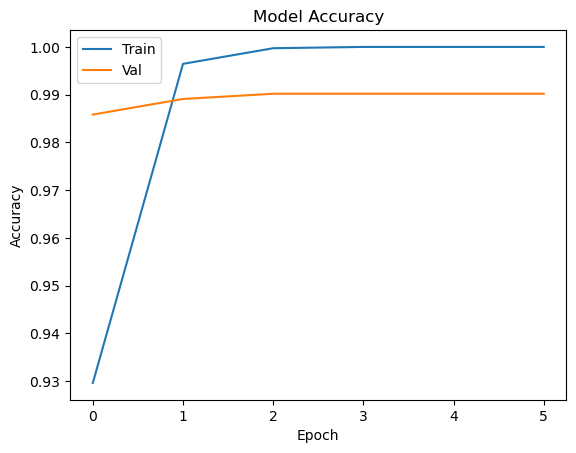

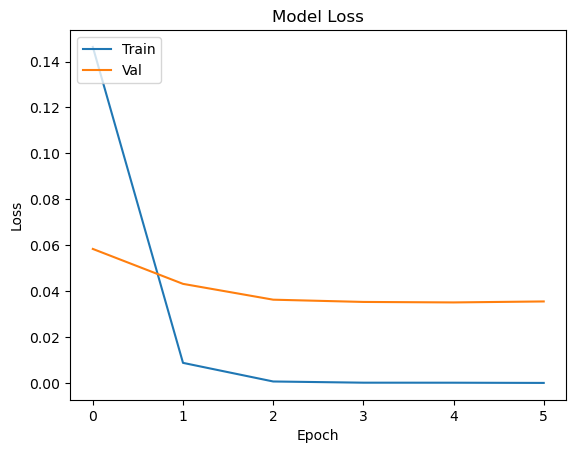

In [162]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
